In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import time
from Helper_fun import time_intersection, generate_temp_range
import os
import datetime as dt
import math
from multiprocessing import Pool
from functools import partial

In [2]:
if os.environ['WORK_DIR']!='':
    WORK_DIR=os.environ['WORK_DIR']
    PyFLEXTRKR_LIB_DIR= os.environ['PyFLEXTRKR_LIB_DIR']
else:
    raise ValueError("PyFLEXTRKR_LIB_DIR environmental variable is empty or doesn't exist") 
min_temp=-35
max_temp=-30

In [3]:
job_output_dir=WORK_DIR+'/Job_output'#'/Old_results_storage/Run12.11_all_t_ranges'

In [4]:
cloudtrack_fp = job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/pixel_path_tracking/20040201.1415_20040201.2000/cloudtracks_20040201_183000.nc'

cloudtrack_data = nc.Dataset(cloudtrack_fp) 
trackstats_data=nc.Dataset(job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/stats/trackstats_final_20040201.1415_20040201.2000.nc')
tracknumbers_data=nc.Dataset(job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/stats/tracknumbers_20040201.1415_20040201.2000.nc')

cloudtracknumber_field=cloudtrack_data.variables['cloudtracknumber'][:,:,:]
cph_field=cloudtrack_data.variables['cph'][:,:,:]
n_tracks=trackstats_data.variables['track_duration'].shape[0]
basetimes=tracknumbers_data.variables['basetimes'][:]


In [5]:
np.count_nonzero(cph_field)

30460

In [6]:
class cloud:
    # def __new__(self, *args, **kwargs):
    #     return super().__new__(self)
    def __init__(self,cloud_id):
        self.id=cloud_id
        self.crit_fraction=0.1
        # Bools inidicating if the cloud has been liquid at any point
        self.is_liq: bool =False
        self.is_mix: bool =False
        self.is_ice: bool =False
        # Max and min cloud size in pixels
        self.max_size:int=0
        self.min_size:int=0

        self.max_water_fraction:float=0.0
        self.max_ice_fraction:float=0.0

        self.track_start_time: dt.datetime=None
        self.track_end_time: dt.datetime=None
        self.track_length = None

        self.glaciation_start_time: dt.datetime=None
        self.glaciation_end_time: dt.datetime=None
    
    def __str__(self):
        return f"{self.is_liq},{self.is_mix},{self.is_ice},"

    def update_status(self,time: dt.datetime, cloud_values: np.array):
        cloud_size=cloud_values.shape[0]
        if cloud_size:
            
            # I assume that water_frac+ice_frac=1
            water_fraction=float(np.count_nonzero(cloud_values==1))/float(cloud_size)
            ice_fraction=float(np.count_nonzero(cloud_values==2))/float(cloud_size)
            assert math.isclose(water_fraction+ice_fraction,1)
            #print(water_fraction)
            #print(water_fraction)
            if not (self.track_start_time):
                self.track_start_time=time

            #Check and set type of cloud
            if water_fraction>1-self.crit_fraction:
                self.is_liq=True
            elif water_fraction>self.crit_fraction:
                self.is_mix=True
            else:
                self.is_ice=True

            self.max_size=max(self.max_size, cloud_size)
            self.max_water_fraction=max(self.max_water_fraction, water_fraction)
            self.max_ice_fraction=max(self.max_ice_fraction, 1-water_fraction)
        else:
            if (not (self.track_end_time)) and self.track_start_time:
                self.track_end_time=time
                self.track_length=self.track_end_time-self.track_start_time
        

In [10]:
#2,5,10,15,38
t_deltas = [5]
min_temp_array, max_temp_array = generate_temp_range(t_deltas)


In [7]:
agg_fact=2


In [8]:
def analyze_current_cloud(track_number,temp_ind,cph_field,cloud_list): 
    try:
        current_cloud=cloud_list[temp_ind][track_number]
    except:
        print(f"Error: {temp_ind,track_number,len(cloud_list)}")
        exit
    #TODO:SPEED UP NEXT TWO LINES (set_cloud_values and update_status)
    cloud_values=cph_field[cloudtracknumber_field==track_number+1]
    current_cloud.update_status(time,cloud_values)

In [13]:

cloud_list=[]
sum_append_cloud=dt.timedelta(seconds=0)
sum_analyze_cloud=dt.timedelta(seconds=0)
sum_load_and_analyze_cloud=dt.timedelta(seconds=0)
sum_load_track_variables=dt.timedelta(seconds=0)
sum_data_loading=dt.timedelta(seconds=0)
sum_current_cloud_load=dt.timedelta(seconds=0)
sum_update_status_time=dt.timedelta(seconds=0)
pool= Pool(os.cpu_count())
for temp_ind in range(len(min_temp_array)):
    # loop_start_time=dt.datetime.now()
    loop_start_time=dt.datetime.now()
    min_temp, max_temp = min_temp_array[temp_ind],max_temp_array[temp_ind]
    #Load datasets
    try:
        cloudtrack_fp = job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/pixel_path_tracking/20040201.1415_20040201.2000/cloudtracks_20040201_183000.nc'
        cloudtrack_data = nc.Dataset(cloudtrack_fp)
        if agg_fact!=0:
            trackstats_data=nc.Dataset(job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}-agg-{agg_fact}/stats/trackstats_final_20040201.1415_20040201.2000.nc')
            tracknumbers_data=nc.Dataset(job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}-agg-{agg_fact}/stats/tracknumbers_20040201.1415_20040201.2000.nc')
        else:
            trackstats_data=nc.Dataset(job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/stats/trackstats_final_20040201.1415_20040201.2000.nc')
            tracknumbers_data=nc.Dataset(job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/stats/tracknumbers_20040201.1415_20040201.2000.nc')
    except: #Exception as inst:
        print(f"Skipping {min_temp} to {max_temp}")
        # print(type(inst))    # the exception type

        # print(inst.args)     # arguments stored in .args

        # print(inst)          # __str__ allows args to be printed directly,

                            # but may be overridden in exception subclasses
        cloud_list.append([])
        continue

    #Load relevant data from datasets into local variables
    cloudtracknumber_field=cloudtrack_data.variables['cloudtracknumber'][:,:,:]
    cph_field=cloudtrack_data.variables['cph'][:,:,:]
    n_tracks=trackstats_data.variables['track_duration'].shape[0]
    basetimes=tracknumbers_data.variables['basetimes'][:]
    n_tracks=trackstats_data.variables['track_duration'].shape[0]
    
    #FIX CLOUD TIMES
    print(n_tracks)
    # append_start_time=dt.datetime.now()
    append_start_time=dt.datetime.now()
    sum_load_track_variables+=append_start_time-loop_start_time
    print(append_start_time-loop_start_time)
    cloud_list.append([cloud(f'{temp_ind}_{i}') for i in range(n_tracks)])
    append_end_time=dt.datetime.now()
    sum_append_cloud+=append_end_time-append_start_time
    print(append_end_time-append_start_time)
    for unix_time in basetimes:
        data_loading_start_time=dt.datetime.now()
        time=dt.datetime.utcfromtimestamp(unix_time)
        time_str=time.strftime("%Y%m%d_%H%M%S")
        print(f'{min_temp} to {max_temp} Loading {time_str}')
        cloudtrack_fp = job_output_dir+f'/T-{abs(round(min_temp))}-{abs(round(max_temp))}/pixel_path_tracking/20040201.1415_20040201.2000/cloudtracks_{time_str}.nc'
        cloudtrack_data = nc.Dataset(cloudtrack_fp) 
        cloudtracknumber_field=cloudtrack_data.variables['cloudtracknumber'][:,:,:]
        cph_field=cloudtrack_data.variables['cph'][:,:,:]
        
        analysis_start_time=dt.datetime.now()
        sum_data_loading+=analysis_start_time-data_loading_start_time
        
        partial_function = partial(analyze_current_cloud, temp_ind=temp_ind, cph_field=cph_field,cloud_list=cloud_list)
        track_number_arr=np.arange(n_tracks)
        # Initialize the pool and map the partial function
        with Pool() as pool:
            pool.map(partial_function, track_number_arr)
        sum_analyze_cloud+=dt.datetime.now()-analysis_start_time
    sum_load_and_analyze_cloud+=dt.datetime.now()-append_end_time
    print(dt.datetime.now()-append_end_time)


912
0:00:00.070566
0:00:00.000555
-5 to 0 Loading 20040201_141500


: 

: 

In [15]:
print(sum_append_cloud)
print(sum_analyze_cloud)
print(sum_load_and_analyze_cloud)
print(sum_load_track_variables)
print(sum_data_loading)
print(sum_current_cloud_load)
print(sum_update_status_time)

0:00:00.087917
0:06:27.534001
0:06:46.172456
0:00:01.258812
0:00:18.635137
0:00:00.121953
0:06:27.161486


In [ ]:
n_tracks

7

In [ ]:
import pandas as pd

columns=["is_liq","is_mix","is_ice","max_water_frac","max_ice_fraction","max_size","min_size","track_start_time","track_length","glaciation_start_time","glaciation_end_time"]
datapoints_per_cloud=len(columns)
for dt_ind in range(len(t_deltas)):
    # TODO Change iteration method in for loop so that for each dt it only goes through the relevant parts of cloud list instead of the whole
    for cloud_list_ind in range(len(cloud_list)):
        dt=t_deltas[dt_ind]
        cloudinfo_df=pd.DataFrame(index=range(len(cloud_list[cloud_list_ind])),columns=columns)
        for cloud_ind in range(len(cloud_list[cloud_list_ind])):
            current_cloud=cloud_list[cloud_list_ind][cloud_ind]
            cloudinfo_df.iloc[cloud_ind]=[current_cloud.is_liq,current_cloud.is_mix,current_cloud.is_ice,current_cloud.max_water_fraction,current_cloud.max_ice_fraction,current_cloud.max_size,current_cloud.min_size,current_cloud.track_start_time,current_cloud.track_length,current_cloud.glaciation_start_time , current_cloud.glaciation_end_time]
        min_temp, max_temp = min_temp_array[cloud_list_ind],max_temp_array[cloud_list_ind]
        cloudinfo_df.to_csv(WORK_DIR+f"/Cloud_analysis/T_{abs(round(min_temp))}_{abs(round(max_temp))}_agg_{agg_fact}.csv")

In [ ]:

n_track_arr=np.empty(len(min_temp_array))
n_glac_arr=np.empty(len(min_temp_array))

for i in range(len(cloud_list)):
    n_track_arr[i]=len(cloud_list[i])

    glaciation_counter=0
    only_ice_counter=0
    only_mix_counter=0
    only_liq_counter=0
    cirrus_counter=0
    for cloud in cloud_list[i]:
        print(f"Cloud max ice fraction: {round(cloud.max_ice_fraction,2)}; Cloud max liq fraction: {round(cloud.max_water_fraction,2)} " )
        if cloud.is_liq+cloud.is_mix+cloud.is_ice==3:
            glaciation_counter+=1
        if (not (cloud.is_liq or cloud.is_mix) ) and cloud.is_ice:
            cirrus_counter+=1
        if (not (cloud.is_ice or cloud.is_mix) ) and cloud.is_liq:
            only_liq_counter+=1
        if (not (cloud.is_liq or cloud.is_ice) ) and cloud.is_mix:
            only_mix_counter+=1
        if cloud.is_ice:
            only_ice_counter+=1
    n_glac_arr[i]=only_mix_counter# glaciations
        
print(f"N glaciations: {glaciation_counter}; N only cirrus: {cirrus_counter}; N only liquid: {only_liq_counter}; N only mix: {only_mix_counter}; N ice at some point: {only_ice_counter}")

Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice fraction: 0.0; Cloud max liq fraction: 1.0 
Cloud max ice 

Used for testing

In [ ]:
# from datetime import datetime, timedelta

# # Function to generate time strings
# def iterate_time(start_date, end_date):
#     current_time = start_date
#     while current_time <= end_date:
#         # Format the time as YYYYMODD_HHMMSS
#         time_str = current_time.strftime("%Y%m%d_%H%M%S")
#         print(time_str)
#         # Increment the time by 15 minutes
#         current_time += timedelta(minutes=15)

# # Example usage
# start_date = datetime(2024, 10, 15, 9, 0, 0)  # Example start date: 15th Oct 2024, 9:00:00
# end_date = datetime(2024, 10, 15, 12, 0, 0)    # Example end date: 15th Oct 2024, 12:00:00

# iterate_time(start_date, end_date)




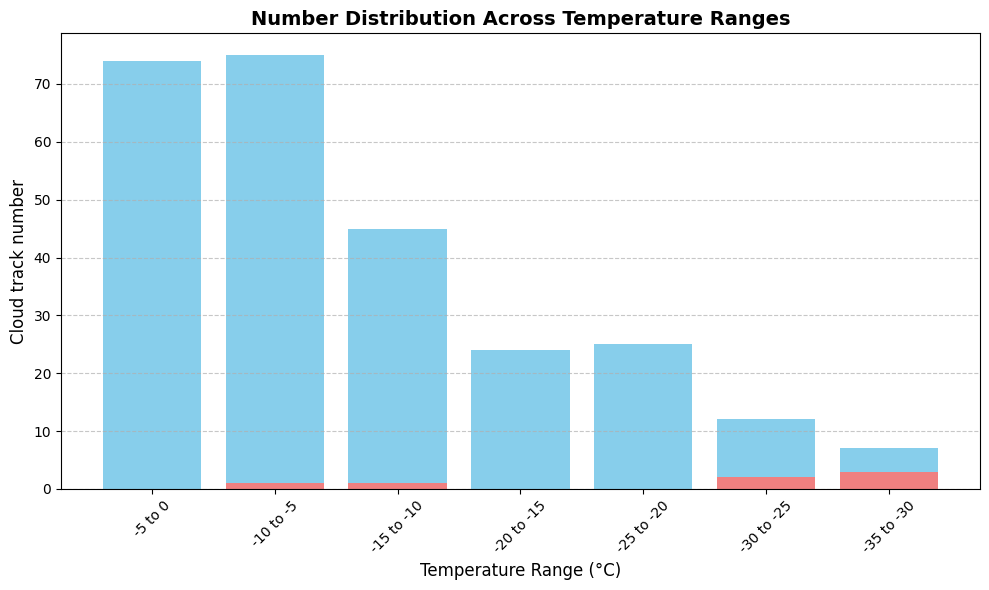

In [ ]:
import matplotlib.pyplot as plt
# Create labels for the x-axis (temperature ranges)


labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range(len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10,6))
plt.bar(labels, n_track_arr[np.where(max_temp_array-min_temp_array==5)], color='skyblue',label="N tracks")
plt.bar(labels, n_glac_arr[np.where(max_temp_array-min_temp_array==5)], color='lightcoral',label="N glaciations")

# Add title and labels
plt.title('Number Distribution Across Temperature Ranges', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Cloud track number', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
# plt.savefig(f'/net/n2o/wolke_scratch/dnikolo/Glaciation_time_estimatior/Result_graphs/TEST_track_distribution_dt5.png',dpi=400)
plt.show()

In [ ]:
basetimes=tracknumbers_data.variables['basetimes'][:]

In [ ]:
time_str=dt.datetime.fromtimestamp(basetimes[0])
time_str.strftime("%Y%m%d_%H%M%S")

'20040201_151500'

In [ ]:
tracknumbers_data.variables['basetimes'][:]

masked_array(data=[1075644900, 1075645800, 1075646700, 1075647600,
                   1075648500, 1075649400, 1075650300, 1075651200,
                   1075652100, 1075653000, 1075653900, 1075654800,
                   1075655700, 1075656600, 1075657500, 1075658400,
                   1075659300, 1075660200, 1075661100, 1075662000,
                   1075662900, 1075663800, 1075664700, 1075665600],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [ ]:
tracknumbers_data.variables

{'ntracks': <class 'netCDF4._netCDF4.Variable'>
 int32 ntracks(time)
     long_name: number of cloud tracks
     units: unitless
 unlimited dimensions: 
 current shape = (1,)
 filling on, default _FillValue of -2147483647 used,
 'basetimes': <class 'netCDF4._netCDF4.Variable'>
 int32 basetimes(nfiles)
     long_name: epoch time (seconds since 01/01/1970 00:00) of cloudid_files
     standard_name: time
     units: seconds since 1970-01-01
     calendar: proleptic_gregorian
 unlimited dimensions: 
 current shape = (24,)
 filling on, default _FillValue of -2147483647 used,
 'cloudid_files': <class 'netCDF4._netCDF4.Variable'>
 |S1 cloudid_files(nfiles, ncharacters, string1)
     long_name: filename of each cloudid file used during tracking
     units: unitless
 unlimited dimensions: 
 current shape = (24, 26, 1)
 filling on, default _FillValue of   used,
 'track_numbers': <class 'netCDF4._netCDF4.Variable'>
 int32 track_numbers(time, nfiles, nclouds)
     _FillValue: -9999
     long_name:

In [ ]:
tracknumbers_data.variables['ntracks']

<class 'netCDF4._netCDF4.Variable'>
int32 ntracks(time)
    long_name: number of cloud tracks
    units: unitless
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of -2147483647 used

In [ ]:
print(tracknumbers_data.variables['ntracks'][:])

[146]
